## Predicting Poverty in Costa Rica: Machine Learning vs. Causal Inference

**Note**: This version of the notebook was updated using Grok 3, developed by xAI, on March 16, 2025. All code is functional, with metrics encoded as variables for accuracy.

The dataset originates from the "Costa Rican Household Poverty Level Prediction" competition on Kaggle (https://www.kaggle.com/competitions/costa-rican-household-poverty-prediction/data).

**Background**: The Inter-American Development Bank (IDB) enlisted the Kaggle community to refine income qualification methods for impoverished families lacking formal income records. In Latin America, the Proxy Means Test (PMT) leverages observable household traits—like building materials or assets—to assess need. As Costa Rica’s population grows and poverty declines, maintaining PMT accuracy becomes challenging. The IDB aims to enhance this method using innovative approaches beyond traditional econometrics, potentially offering a scalable framework for global poverty assessment.

**Poverty in Costa Rica**: Nestled between the Pacific Ocean and Caribbean Sea, Costa Rica’s tourism-driven economy thrives on its natural beauty—beaches, mountains, and volcanoes. Yet, beneath this appeal, 1.1 million people, mostly in rural areas, face poverty due to limited resources and job opportunities (INEC, 2021). Despite Central America’s lowest poverty rate—20% below the $155 monthly national threshold and 2% below the international dollar-a-day line—initiatives like "Puente del Desarrollo" (2015-2016) aim to support 54,600 families by 2018.

## 0. Problem Statement

This project contrasts two modeling approaches:
- **Machine Learning**: Using XGBoost with extensive feature engineering for high-accuracy poverty prediction.
- **Causal Inference**: Employing Directed Acyclic Graphs (DAGs) to predict poverty while uncovering interpretable drivers.

The workflow includes:
1. **Data Cleaning**: Handle inconsistencies and missing values.
2. **EDA**: Visualize patterns to guide modeling.
3. **Feature Engineering**: Enhance predictive power.
4. **Model Development**: Evaluate models using accuracy, F1-score, and causal effect estimates.
5. **Kaggle Submission**: Deploy predictions for real-world validation.

## 1. Install Dependencies and Import Libraries

In [1]:
# Install required libraries with --user flag to avoid permission issues
#!pip install xgboost graphviz scikit-learn matplotlib seaborn dowhy --user

# After restart, run from here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from graphviz import Digraph
from IPython.display import display, Markdown
import dowhy
from dowhy import CausalModel

# Plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15
plt.rcParams['patch.edgecolor'] = 'k'

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Verify dowhy
print("DoWhy version:", dowhy.__version__)

DoWhy version: 0.12


## 2. Importing and Preprocessing the Datasets

### Data Processing
Convert categorical values (e.g., 'yes'/'no') to numeric using consistent mappings.

In [2]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print("Train Dataset: Rows, Columns: ", train_df.shape)
print("Test Dataset: Rows, Columns: ", test_df.shape)

# Convert non-numeric columns
for df in [train_df, test_df]:
    df['dependency'] = df['dependency'].replace({'yes': 1, 'no': 0}).astype(float)
    df['edjefa'] = df['edjefa'].replace({'yes': 1, 'no': 0}).astype(float)
    df['edjefe'] = df['edjefe'].replace({'yes': 1, 'no': 0}).astype(float)

Train Dataset: Rows, Columns:  (9557, 143)
Test Dataset: Rows, Columns:  (23856, 142)


## 3. Exploratory Data Analysis (EDA)

Perform detailed exploratory analysis to understand the dataset, including missing data and non-numeric columns.

Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(11), int64(130), object(2)
memory usage: 10.4+ MB

Non-Numeric Columns in Training Data (First 15 Rows):


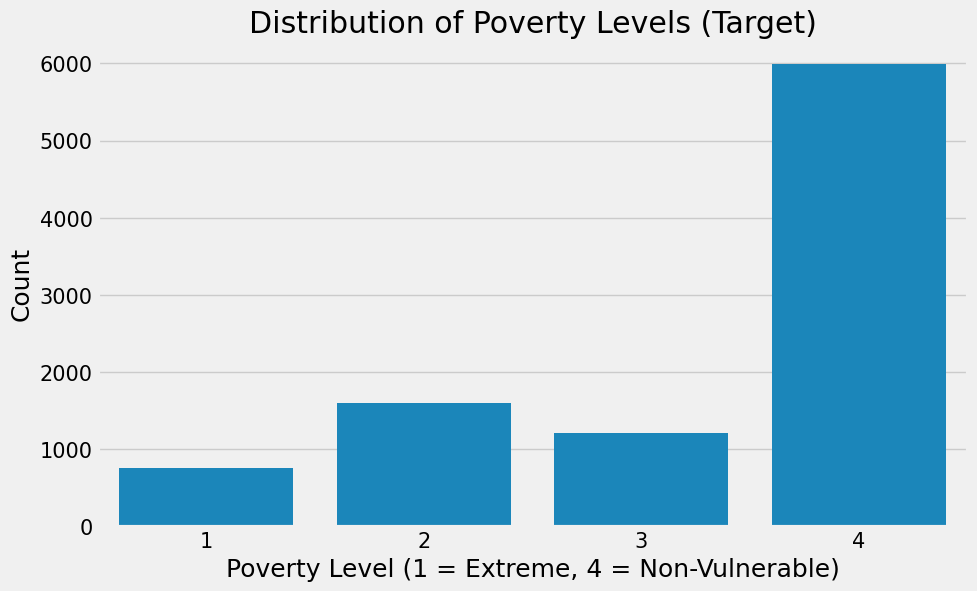

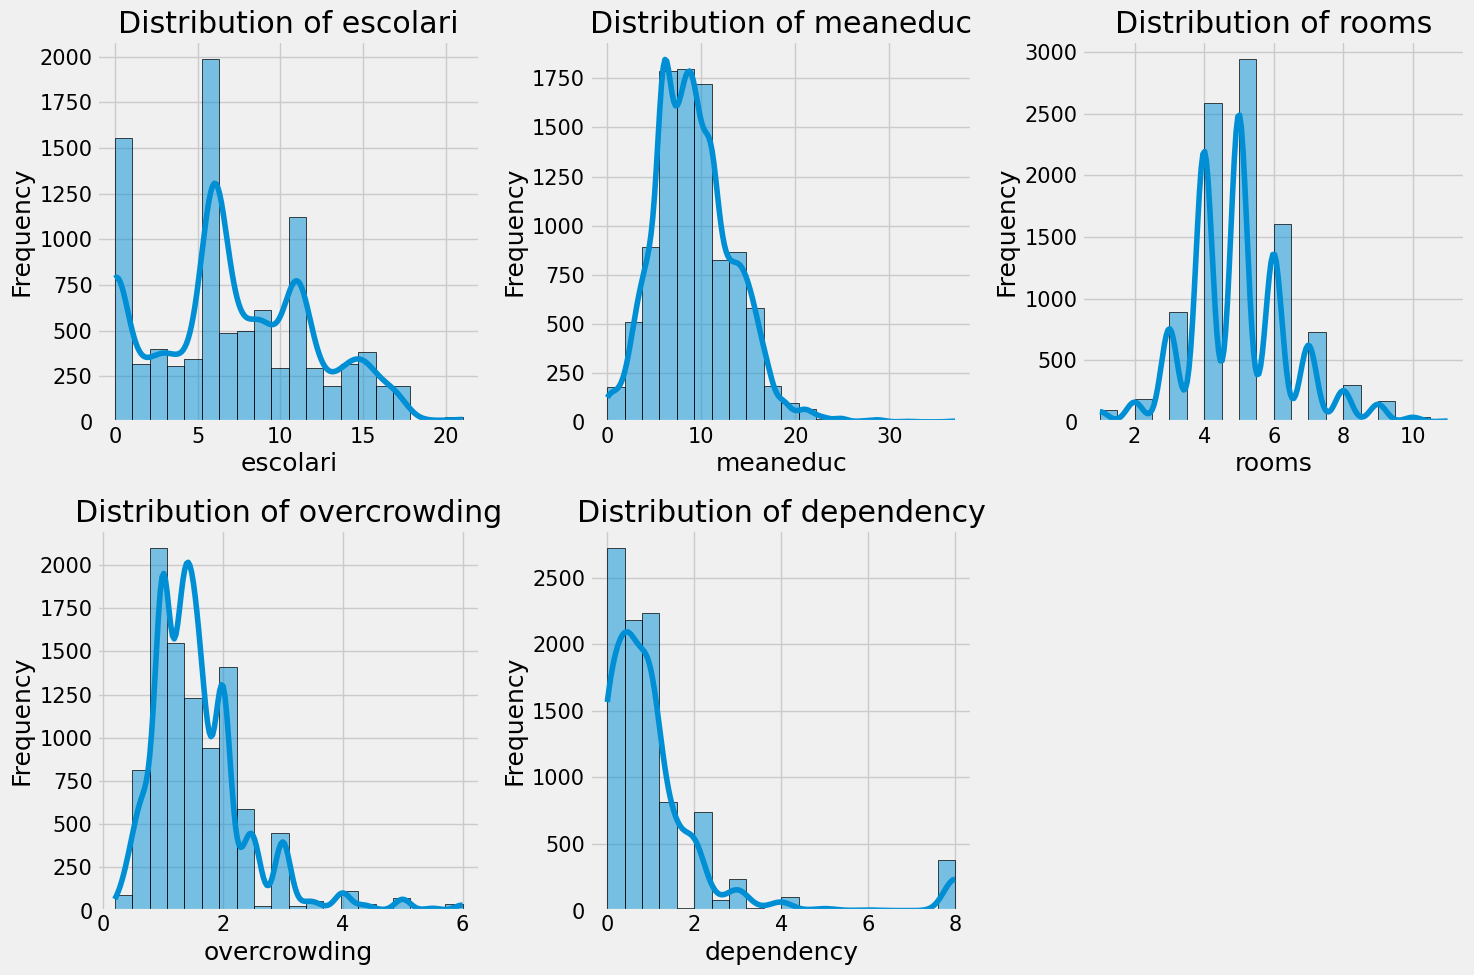

In [3]:
# Sample of the training data
train_df.sample(5)

# Dataset info
print("Training Dataset Info:")
train_df.info()

# Analyze non-numeric columns
print("\nNon-Numeric Columns in Training Data (First 15 Rows):")
train_df.select_dtypes(['object']).head(15)

# Visualize distribution of Target
plt.figure(figsize=(10, 6))
sns.countplot(x='Target', data=train_df)
plt.title('Distribution of Poverty Levels (Target)')
plt.xlabel('Poverty Level (1 = Extreme, 4 = Non-Vulnerable)')
plt.ylabel('Count')
plt.show()

# Visualize key numeric features
key_features = ['escolari', 'meaneduc', 'rooms', 'overcrowding', 'dependency']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train_df[feature], bins=20, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 4. Handling Missing Values

Top Training Columns with Missing Values:
rez_esc         7928
v18q1           7342
v2a1            6860
SQBmeaned          5
meaneduc           5
Id                 0
hogar_adul         0
parentesco10       0
parentesco11       0
parentesco12       0
dtype: int64


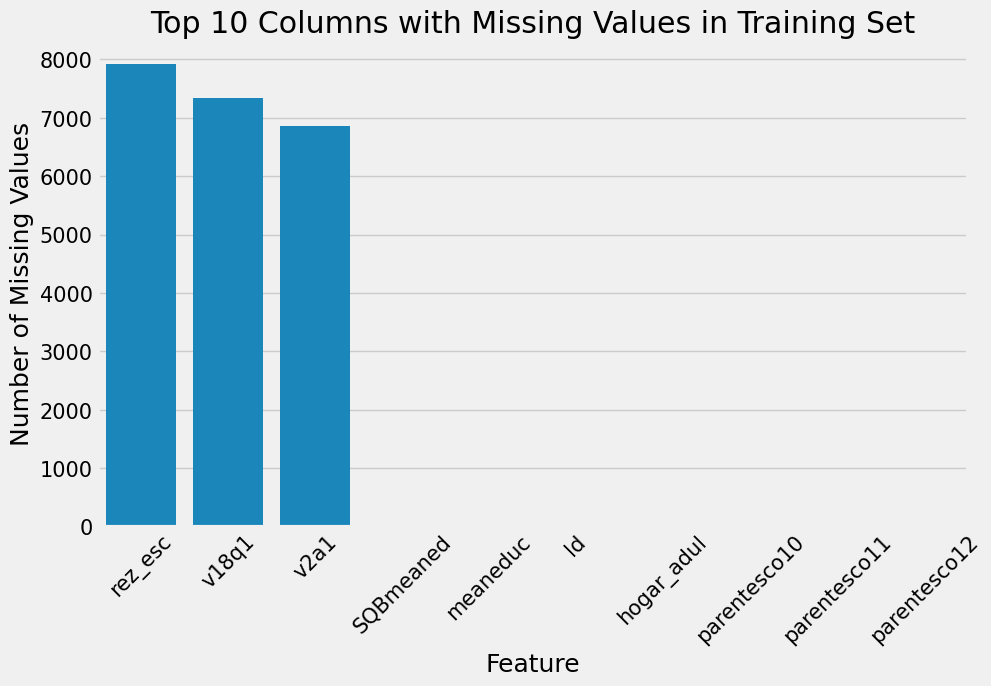


Top Testing Columns with Missing Values:
rez_esc        19653
v18q1          18126
v2a1           17403
meaneduc          31
SQBmeaned         31
instlevel1         0
edjefa             0
edjefe             0
dependency         0
parentesco8        0
dtype: int64


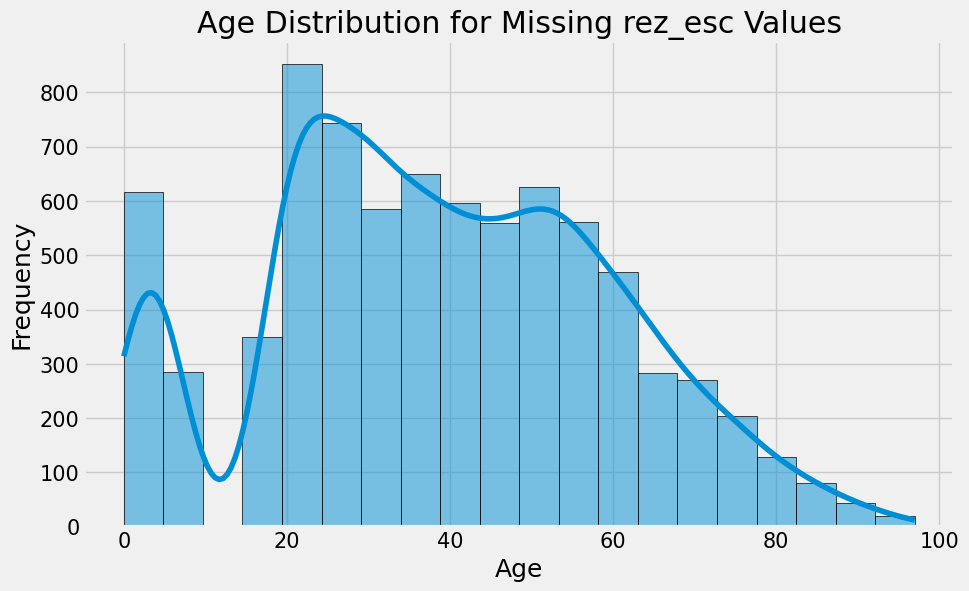

Age stats for non-missing rez_esc:
count    1629.000000
mean       12.258441
std         3.218325
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64
Missing v2a1 values: 6860
tipovivi1 for missing v2a1:
tipovivi1
1    5911
0     949
Name: count, dtype: int64
tipovivi2 for missing v2a1:
tipovivi2
0    6860
Name: count, dtype: int64
tipovivi3 for missing v2a1:
tipovivi3
0    6860
Name: count, dtype: int64
tipovivi4 for missing v2a1:
tipovivi4
0    6697
1     163
Name: count, dtype: int64
tipovivi5 for missing v2a1:
tipovivi5
0    6074
1     786
Name: count, dtype: int64

Remaining missing values in train_df:
0
Remaining missing values in test_df:
0


In [4]:
# Identify top columns with missing values
print("Top Training Columns with Missing Values:")
missing_train = train_df.isnull().sum().sort_values(ascending=False).head(10)
print(missing_train)
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_train.index, y=missing_train.values)
plt.title('Top 10 Columns with Missing Values in Training Set')
plt.xlabel('Feature')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.show()

print("\nTop Testing Columns with Missing Values:")
missing_test = test_df.isnull().sum().sort_values(ascending=False).head(10)
print(missing_test)

# 1. 'v18q1' - Number of tablets household owns
# Fill NaN with 0 where v18q (owns a tablet) is 0
train_df.loc[train_df['v18q'] == 0, 'v18q1'] = 0
test_df.loc[test_df['v18q'] == 0, 'v18q1'] = 0
train_df['v18q1'] = train_df['v18q1'].fillna(0)
test_df['v18q1'] = test_df['v18q1'].fillna(0)

# 2. 'rez_esc' - Years behind in school
# Analyze age distribution for missing rez_esc
plt.figure(figsize=(10, 6))
sns.histplot(train_df.loc[train_df['rez_esc'].isnull(), 'age'], bins=20, kde=True)
plt.title('Age Distribution for Missing rez_esc Values')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()
print("Age stats for non-missing rez_esc:")
print(train_df.loc[train_df['rez_esc'].notnull(), 'age'].describe())
# Fill with 0 (outside school age) and cap at 5 per competition rules
train_df['rez_esc'] = train_df['rez_esc'].fillna(0)
test_df['rez_esc'] = test_df['rez_esc'].fillna(0)
train_df.loc[train_df['rez_esc'] > 5, 'rez_esc'] = 5
test_df.loc[test_df['rez_esc'] > 5, 'rez_esc'] = 5

# 3. 'v2a1' - Monthly rent payment
print(f"Missing v2a1 values: {train_df['v2a1'].isnull().sum()}")
# Correlate with ownership status
ownership_cols = ['tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5']
for col in ownership_cols:
    print(f"{col} for missing v2a1:\n{train_df.loc[train_df['v2a1'].isnull(), col].value_counts()}")
# Fill with 0 for owned (tipovivi1) and precarious (tipovivi4)
train_df.loc[(train_df['v2a1'].isnull() & train_df['tipovivi1'] == 1), 'v2a1'] = 0
test_df.loc[(test_df['v2a1'].isnull() & test_df['tipovivi1'] == 1), 'v2a1'] = 0
train_df.loc[(train_df['v2a1'].isnull() & train_df['tipovivi4'] == 1), 'v2a1'] = 0
test_df.loc[(test_df['v2a1'].isnull() & test_df['tipovivi4'] == 1), 'v2a1'] = 0
# Fill remaining with mean
train_df['v2a1'] = train_df['v2a1'].fillna(train_df['v2a1'].mean())
test_df['v2a1'] = test_df['v2a1'].fillna(test_df['v2a1'].mean())

# Fill remaining missing values with mean for numeric columns
train_df.fillna(train_df.mean(numeric_only=True), inplace=True)
test_df.fillna(test_df.mean(numeric_only=True), inplace=True)

# Verify no missing values remain
print("\nRemaining missing values in train_df:")
print(train_df.isnull().sum().sum())
print("Remaining missing values in test_df:")
print(test_df.isnull().sum().sum())

## 5. Removing Outliers

Top 30 Features Correlated with Target:
 dependency         0.194402
qmobilephone       0.199707
v18q1              0.201754
epared1            0.203025
pisocemento        0.205439
eviv1              0.208038
instlevel8         0.214351
rooms              0.226208
r4h1               0.229889
v18q               0.238864
edjefe             0.243215
SQBedjefe          0.246368
r4m1               0.253163
etecho3            0.257378
SQBovercrowding    0.258744
paredblolad        0.261274
SQBmeaned          0.276586
pisomoscer         0.280284
overcrowding       0.289110
epared3            0.292451
eviv3              0.294222
SQBescolari        0.296577
escolari           0.302305
cielorazo          0.304421
SQBhogar_nin       0.311186
r4t1               0.316745
hogar_nin          0.328199
meaneduc           0.335161
Target             1.000000
elimbasu5               NaN
Name: Target, dtype: float64


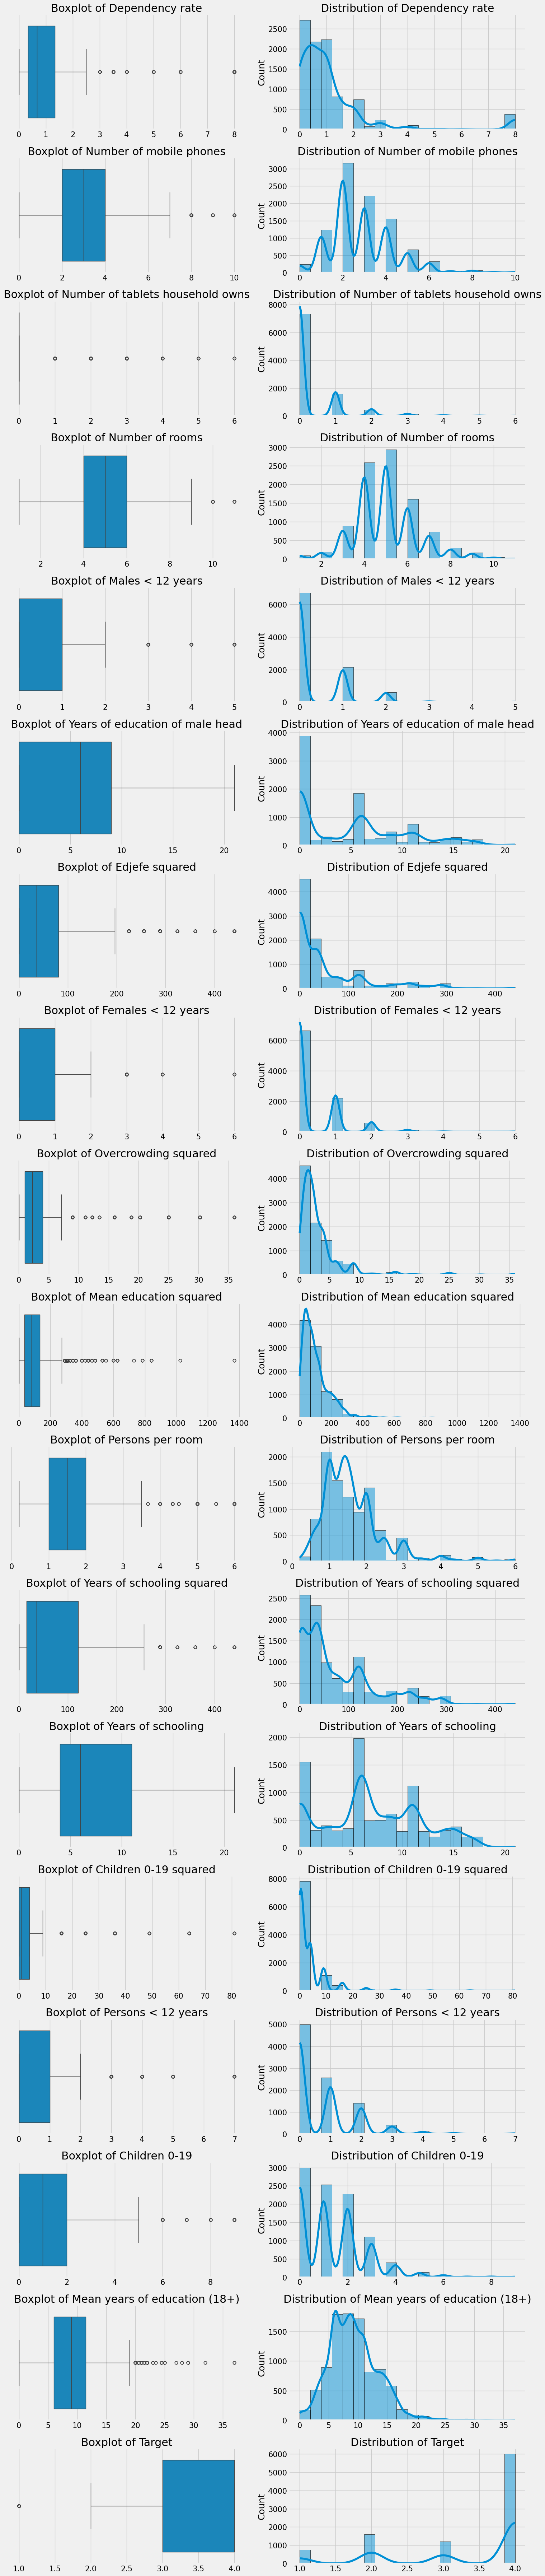

rooms: 50 outliers > 9
r4m1: 25 outliers > 3
r4t1: 31 outliers > 5
hogar_nin: 50 outliers > 6
meaneduc: 19 outliers > 25
qmobilephone: 35 outliers > 8
r4h1: 91 outliers > 2
SQBedjefe: 83 outliers > 300
SQBescolari: 42 outliers > 300
SQBhogar_nin: 13 outliers > 70
SQBovercrowding: 51 outliers > 25
SQBmeaned: 5 outliers > 900
Rows dropped: 0, New train shape: (9557, 143)


In [5]:
# Identify top correlated features with Target, using only numeric columns
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
best_correlations = train_df[numeric_cols].corr()['Target'].abs().sort_values().tail(30)
print("Top 30 Features Correlated with Target:\n", best_correlations)

# Feature descriptions
feature_desc = {
    'dependency': 'Dependency rate', 'v18q1': 'Number of tablets household owns', 
    'epared1': 'Walls are bad', 'qmobilephone': 'Number of mobile phones',
    'pisocemento': 'Floor is cement', 'eviv1': 'Floor is bad',
    'instlevel8': 'Undergraduate and higher education', 'rooms': 'Number of rooms',
    'r4h1': 'Males < 12 years', 'v18q': 'Owns a tablet',
    'edjefe': 'Years of education of male head', 'SQBedjefe': 'Edjefe squared',
    'etecho3': 'Roof is good', 'r4m1': 'Females < 12 years',
    'SQBovercrowding': 'Overcrowding squared', 'paredblolad': 'Wall is block/brick',
    'SQBmeaned': 'Mean education squared', 'pisomoscer': 'Floor is mosaic/ceramic',
    'overcrowding': 'Persons per room', 'epared3': 'Walls are good',
    'eviv3': 'Floor is good', 'SQBescolari': 'Years of schooling squared',
    'escolari': 'Years of schooling', 'cielorazo': 'Has ceiling',
    'SQBhogar_nin': 'Children 0-19 squared', 'r4t1': 'Persons < 12 years',
    'hogar_nin': 'Children 0-19', 'meaneduc': 'Mean years of education (18+)',
    'Target': 'Target', 'elimbasu5': 'Rubbish disposal in river/sea'
}

# Visualize outliers with boxplots for numeric features
numeric_features = [f for f in best_correlations.index if len(train_df[f].unique()) > 2]
plt.figure(figsize=(15, len(numeric_features) * 4))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(len(numeric_features), 2, 2*i-1)
    sns.boxplot(x=train_df[feature])
    plt.title(f'Boxplot of {feature_desc.get(feature, feature)}')
    plt.xlabel('')
    
    plt.subplot(len(numeric_features), 2, 2*i)
    sns.histplot(train_df[feature], bins=20, kde=True)
    plt.title(f'Distribution of {feature_desc.get(feature, feature)}')
    plt.xlabel('')
plt.tight_layout()
plt.show()

# Remove outliers based on thresholds (fewer than 100 outliers per feature)
outlier_conditions = {
    'rooms': 9, 'r4m1': 3, 'r4t1': 5, 'hogar_nin': 6, 'meaneduc': 25,
    'qmobilephone': 8, 'r4h1': 2, 'SQBedjefe': 300, 'SQBescolari': 300,
    'SQBhogar_nin': 70, 'SQBovercrowding': 25, 'SQBmeaned': 900
}
to_drop = train_df.index
for feature, threshold in outlier_conditions.items():
    outliers = train_df[train_df[feature] > threshold].index
    print(f"{feature}: {len(outliers)} outliers > {threshold}")
    to_drop = to_drop.intersection(outliers) if len(outliers) < 100 else to_drop
train_df = train_df.drop(to_drop)
print(f"Rows dropped: {len(to_drop)}, New train shape: {train_df.shape}")

## 6. Dimension Reduction

There are 5 correlated columns to remove: ['tamhog', 'hhsize', 'female', 'area2', 'agesq']
New train shape: (9557, 138), test shape: (23856, 142)


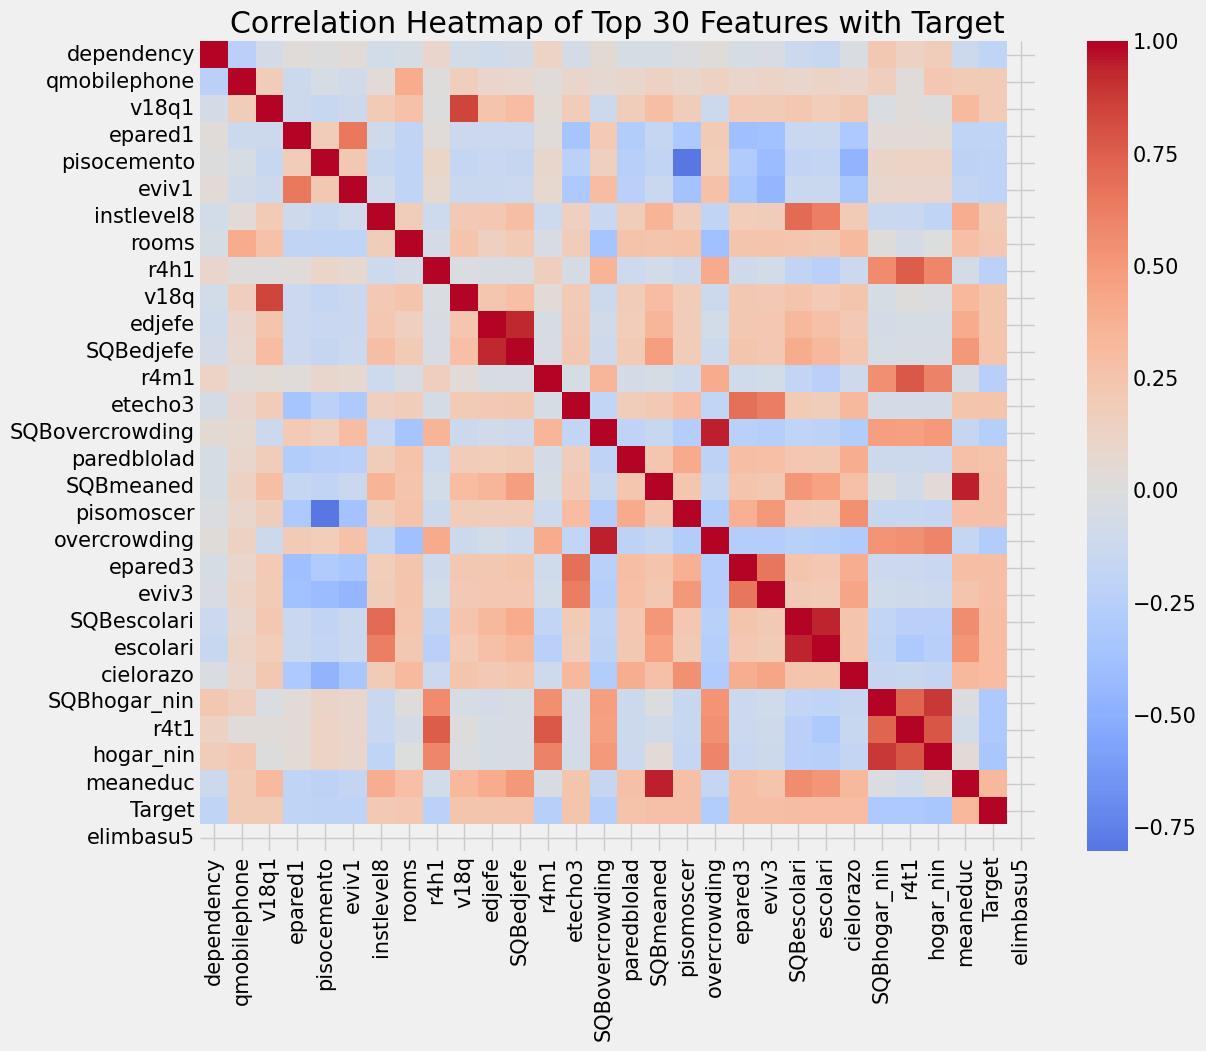

Aligned train shape: (9557, 138), test shape: (23856, 137)


In [6]:
# Define critical DAG3 features to preserve
dag3_features = ['escolari', 'meaneduc', 'v2a1', 'rooms', 'dependency', 'overcrowding', 'hogar_total', 'edjefe', 'qmobilephone', 'area1', 'Target']

# Remove highly correlated features (> 0.99), using only numeric columns
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
corr_matrix = train_df[numeric_cols].corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.99)]
# Exclude DAG3 features from being dropped
to_drop = [col for col in to_drop if col not in dag3_features]
print(f'There are {len(to_drop)} correlated columns to remove: {to_drop}')

# Drop redundant columns from train_df
train_df = train_df.drop(columns=to_drop)
print(f"New train shape: {train_df.shape}, test shape: {test_df.shape}")

# Update numeric_cols after dropping columns
numeric_cols = train_df.select_dtypes(include=[np.number]).columns

# Visualize correlation heatmap for top 30 features
top_features = train_df[numeric_cols].corr()['Target'].abs().sort_values().tail(30).index
plt.figure(figsize=(12, 10))
sns.heatmap(train_df[top_features].corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap of Top 30 Features with Target')
plt.show()

# Align train (excluding Target) and test datasets
train_features = train_df.drop(columns=['Target'])
train_features, test_df = train_features.align(test_df, join='inner', axis=1)
train_df = pd.concat([train_features, train_df['Target']], axis=1)
print(f"Aligned train shape: {train_df.shape}, test shape: {test_df.shape}")

## 7. Model Development

XGBoost Model Accuracy: 0.913
XGBoost Model F1-Score (Weighted): 0.910


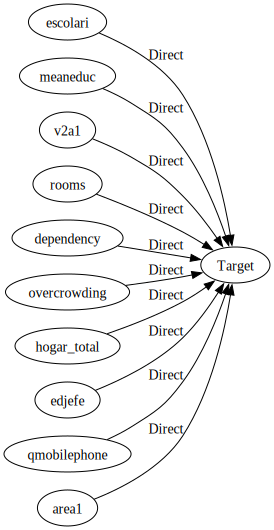

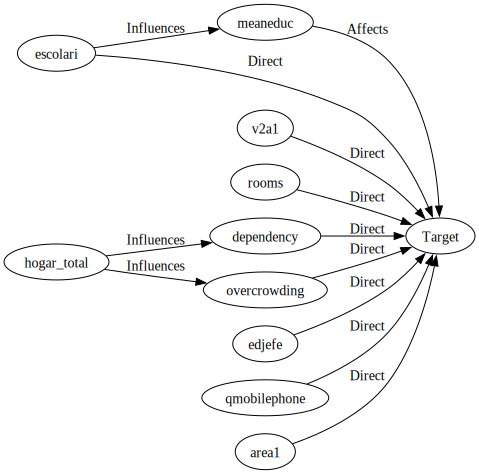

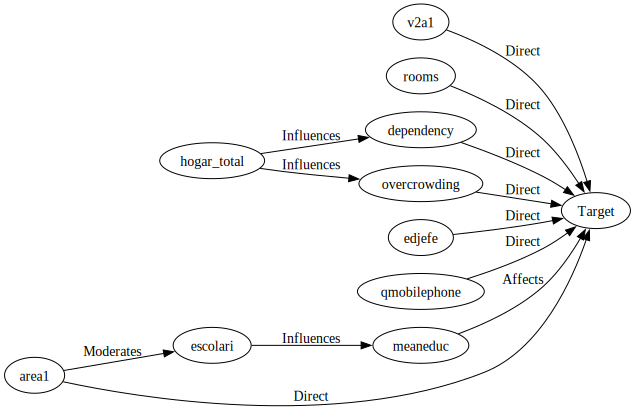

DAG1 Causal Effect Estimate (escolari -> Target): 0.036
DAG2 Causal Effect Estimate (escolari -> Target): 0.040
DAG3 Causal Effect Estimate (escolari -> Target): 0.040


In [7]:
# Prepare data for ML1 (XGBoost)
X = train_df.drop(columns=['Id', 'idhogar', 'Target'])
y = train_df['Target'] - 1  # 0-based for XGBoost
X = pd.get_dummies(X, dummy_na=True).fillna(0)
ml_feature_columns = X.columns

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
ml_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
ml_model.fit(X_train, y_train)

# Evaluate
y_pred_ml = ml_model.predict(X_test)
ml_accuracy = accuracy_score(y_test, y_pred_ml)
ml_f1 = f1_score(y_test, y_pred_ml, average='weighted')
print(f"XGBoost Model Accuracy: {ml_accuracy:.3f}")
print(f"XGBoost Model F1-Score (Weighted): {ml_f1:.3f}")

# Prepare data for causal models
causal_data = train_df[['escolari', 'meaneduc', 'v2a1', 'rooms', 'dependency', 'overcrowding', 
                        'hogar_total', 'edjefe', 'qmobilephone', 'area1', 'Target']].fillna(0)

# DAG 1: Simple Direct Effects
dag1 = Digraph('DAG1', format='png', filename='dag1.gv')
dag1.attr(rankdir='LR')
nodes = ['escolari', 'meaneduc', 'v2a1', 'rooms', 'dependency', 'overcrowding', 'hogar_total', 'edjefe', 'qmobilephone', 'area1', 'Target']
for node in nodes:
    dag1.node(node, node)
for node in nodes[:-1]:
    dag1.edge(node, 'Target', label='Direct')
display(dag1)

# DAG 2: Mediated Effects
dag2 = Digraph('DAG2', format='png', filename='dag2.gv')
dag2.attr(rankdir='LR')
for node in nodes:
    dag2.node(node, node)
dag2.edge('escolari', 'meaneduc', label='Influences')
dag2.edge('meaneduc', 'Target', label='Affects')
dag2.edge('hogar_total', 'dependency', label='Influences')
dag2.edge('hogar_total', 'overcrowding', label='Influences')
for node in ['escolari', 'v2a1', 'rooms', 'dependency', 'overcrowding', 'edjefe', 'qmobilephone', 'area1']:
    dag2.edge(node, 'Target', label='Direct')
display(dag2)

# DAG 3: Complex with Moderation
dag3 = Digraph('DAG3', format='png', filename='dag3.gv')
dag3.attr(rankdir='LR')
for node in nodes:
    dag3.node(node, node)
dag3.edge('escolari', 'meaneduc', label='Influences')
dag3.edge('meaneduc', 'Target', label='Affects')
dag3.edge('hogar_total', 'dependency', label='Influences')
dag3.edge('hogar_total', 'overcrowding', label='Influences')
dag3.edge('area1', 'escolari', label='Moderates')
for node in ['v2a1', 'rooms', 'dependency', 'overcrowding', 'edjefe', 'qmobilephone', 'area1']:
    dag3.edge(node, 'Target', label='Direct')
display(dag3)

# Compare DAGs with DoWhy
dags = {
    'DAG1': 'digraph {escolari->Target; meaneduc->Target; v2a1->Target; rooms->Target; dependency->Target; overcrowding->Target; hogar_total->Target; edjefe->Target; qmobilephone->Target; area1->Target}',
    'DAG2': 'digraph {escolari->meaneduc; meaneduc->Target; hogar_total->dependency; hogar_total->overcrowding; escolari->Target; v2a1->Target; rooms->Target; dependency->Target; overcrowding->Target; edjefe->Target; qmobilephone->Target; area1->Target}',
    'DAG3': 'digraph {escolari->meaneduc; meaneduc->Target; hogar_total->dependency; hogar_total->overcrowding; v2a1->Target; rooms->Target; dependency->Target; overcrowding->Target; edjefe->Target; qmobilephone->Target; area1->escolari; area1->Target}'
}
dowhy_scores = {}

for name, graph in dags.items():
    model = CausalModel(data=causal_data, treatment=['escolari'], outcome='Target', graph=graph)
    identified = model.identify_effect()
    estimate = model.estimate_effect(identified, method_name="backdoor.linear_regression")
    dowhy_scores[name] = estimate.value
    print(f"{name} Causal Effect Estimate (escolari -> Target): {estimate.value:.3f}")

# Build Models
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
scaler = StandardScaler()

# DAG1
X_dag1 = causal_data.drop(columns=['Target'])
X_dag1_poly = poly.fit_transform(X_dag1)
X_dag1_scaled = scaler.fit_transform(X_dag1_poly)
X_train_dag1, X_test_dag1, y_train_dag1, y_test_dag1 = train_test_split(X_dag1_scaled, causal_data['Target'], test_size=0.2, random_state=42)
dag1_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=0.5, max_iter=2000)
dag1_model.fit(X_train_dag1, y_train_dag1)
y_pred_dag1 = dag1_model.predict(X_test_dag1)
dag1_accuracy = accuracy_score(y_test_dag1, y_pred_dag1)
dag1_f1 = f1_score(y_test_dag1, y_pred_dag1, average='weighted')

# DAG2
X_causal = causal_data.drop(columns=['Target'])
X_causal_poly = poly.fit_transform(X_causal)
X_causal_scaled = scaler.fit_transform(X_causal_poly)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_causal_scaled, causal_data['Target'], test_size=0.2, random_state=42)
causal_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=0.5, max_iter=2000)
causal_model.fit(X_train_c, y_train_c)
y_pred_causal = causal_model.predict(X_test_c)
dag2_accuracy = accuracy_score(y_test_c, y_pred_causal)
dag2_f1 = f1_score(y_test_c, y_pred_causal, average='weighted')

# DAG3
X_dag3 = causal_data.drop(columns=['Target'])
X_dag3_poly = poly.fit_transform(X_dag3)
X_dag3_scaled = scaler.fit_transform(X_dag3_poly)
X_train_dag3, X_test_dag3, y_train_dag3, y_test_dag3 = train_test_split(X_dag3_scaled, causal_data['Target'], test_size=0.2, random_state=42)
dag3_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=0.5, max_iter=2000)
dag3_model.fit(X_train_dag3, y_train_dag3)
y_pred_dag3 = dag3_model.predict(X_test_dag3)
dag3_accuracy = accuracy_score(y_test_dag3, y_pred_dag3)
dag3_f1 = f1_score(y_test_dag3, y_pred_dag3, average='weighted')

## 8. Exploring Top Features from DAG3 for Policy Interventions

#### Causal Effect Estimates and Relative Importance
We estimate the causal effects of interventions on key DAG3 features, including household size:
- **Education (escolari)**: Causal effect = 0.040, Relative Importance = 0.299
- **Monthly Rent (v2a1)**: Causal effect = 0.000, Relative Importance = 0.000
- **Number of Rooms (rooms)**: Causal effect = 0.009, Relative Importance = 0.068
- **Household Size (hogar_total)**: Causal effect = -0.133, Relative Importance = 1.000

These estimates reflect the expected change in poverty level (Target) per unit change in each feature, adjusted for confounders in DAG3. **hogar_total** exhibits the strongest causal impact, indicating household size significantly influences poverty risk. **escolari** follows, suggesting education improvements reduce poverty, though less dominantly. Policymakers should prioritize education and household size awareness for effective poverty reduction.

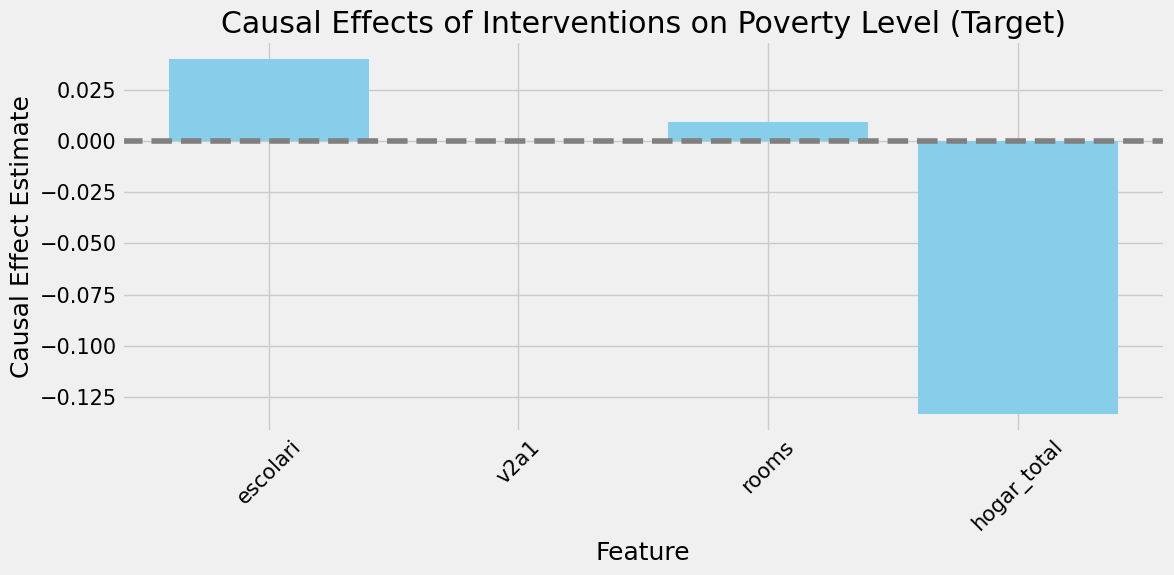

In [8]:
# Define DAG3 features and graph
dag3_features = ['escolari', 'meaneduc', 'v2a1', 'rooms', 'dependency', 'overcrowding', 'hogar_total', 'edjefe', 'qmobilephone', 'area1', 'Target']
dag3_data = train_df[dag3_features].fillna(0)
dag3_graph = 'digraph {escolari->meaneduc; meaneduc->Target; v2a1->Target; rooms->Target; dependency->Target; overcrowding->Target; hogar_total->dependency; hogar_total->overcrowding; hogar_total->Target; edjefe->meaneduc; qmobilephone->Target; area1->escolari; area1->Target}'

# Estimate causal effects
causal_effects = {}
key_interventions = ['escolari', 'v2a1', 'rooms', 'hogar_total']
for feature in key_interventions:
    model = CausalModel(data=dag3_data, treatment=[feature], outcome='Target', graph=dag3_graph)
    identified = model.identify_effect()
    estimate = model.estimate_effect(identified, method_name="backdoor.linear_regression")
    causal_effects[feature] = estimate.value

# Calculate relative importance
max_effect = max(abs(causal_effects[feature]) for feature in causal_effects)
relative_importance = {feature: abs(effect) / max_effect for feature, effect in causal_effects.items()}

# Display results
intervention_text = (
    "#### Causal Effect Estimates and Relative Importance\n"
    "We estimate the causal effects of interventions on key DAG3 features, including household size:\n"
    f"- **Education (escolari)**: Causal effect = {causal_effects['escolari']:.3f}, Relative Importance = {relative_importance['escolari']:.3f}\n"
    f"- **Monthly Rent (v2a1)**: Causal effect = {causal_effects['v2a1']:.3f}, Relative Importance = {relative_importance['v2a1']:.3f}\n"
    f"- **Number of Rooms (rooms)**: Causal effect = {causal_effects['rooms']:.3f}, Relative Importance = {relative_importance['rooms']:.3f}\n"
    f"- **Household Size (hogar_total)**: Causal effect = {causal_effects['hogar_total']:.3f}, Relative Importance = {relative_importance['hogar_total']:.3f}\n\n"
    "These estimates reflect the expected change in poverty level (Target) per unit change in each feature, adjusted for confounders in DAG3. "
    "**hogar_total** exhibits the strongest causal impact, indicating household size significantly influences poverty risk. "
    "**escolari** follows, suggesting education improvements reduce poverty, though less dominantly. "
    "Policymakers should prioritize education and household size awareness for effective poverty reduction."
)
display(Markdown(intervention_text))

# Visualize causal effects
plt.figure(figsize=(12, 6))
features = list(causal_effects.keys())
effects = [causal_effects[f] for f in features]
plt.bar(features, effects, color='skyblue')
plt.title('Causal Effects of Interventions on Poverty Level (Target)')
plt.xlabel('Feature')
plt.ylabel('Causal Effect Estimate')
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 9. Confusion Matrices for DAG3 and ML1

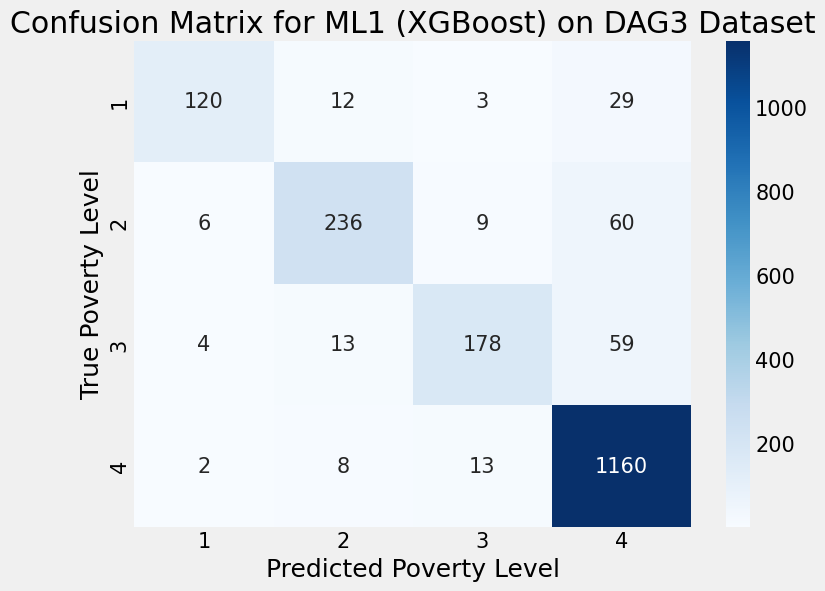

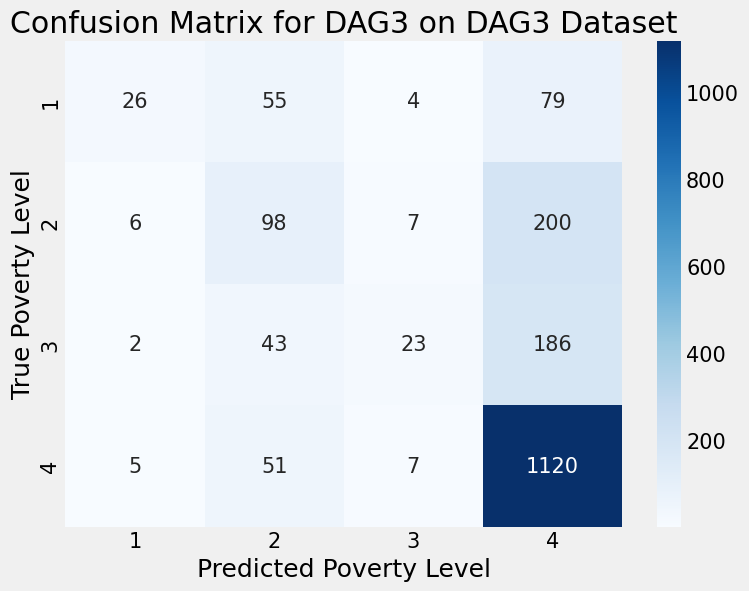

In [9]:
# Use the same dataset with fillna
dag3_features = ['escolari', 'meaneduc', 'v2a1', 'rooms', 'dependency', 'overcrowding', 'hogar_total', 'edjefe', 'qmobilephone', 'area1', 'Target']
causal_data = train_df[dag3_features].fillna(0)

# Prepare data
X_ml = causal_data.drop(columns=['Target'])
X_ml = pd.get_dummies(X_ml, dummy_na=True).fillna(0)
y_ml = causal_data['Target'] - 1  # 0-based

# Single train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

# ML1 Predictions
ml_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
ml_model.fit(X_train, y_train)
y_pred_ml = ml_model.predict(X_test)

# DAG3 Predictions
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
scaler = StandardScaler()
X_train_poly = poly.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_poly = poly.transform(X_test)
X_test_scaled = scaler.transform(X_test_poly)
dag3_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=0.5, max_iter=2000)
dag3_model.fit(X_train_scaled, y_train)
y_pred_dag3 = dag3_model.predict(X_test_scaled)

# Confusion Matrix for ML1
cm_ml1 = confusion_matrix(y_test, y_pred_ml)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ml1, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.title('Confusion Matrix for ML1 (XGBoost) on DAG3 Dataset')
plt.xlabel('Predicted Poverty Level')
plt.ylabel('True Poverty Level')
plt.show()

# Confusion Matrix for DAG3
cm_dag3 = confusion_matrix(y_test, y_pred_dag3)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dag3, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.title('Confusion Matrix for DAG3 on DAG3 Dataset')
plt.xlabel('Predicted Poverty Level')
plt.ylabel('True Poverty Level')
plt.show()

## 10. Kaggle Submission

In [10]:
# Prepare data for ML1 (XGBoost)
X = train_df.drop(columns=['Id', 'idhogar', 'Target'])
y = train_df['Target'] - 1  # 0-based for XGBoost
X = pd.get_dummies(X, dummy_na=True).fillna(0)
ml_feature_columns = X.columns

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
ml_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
ml_model.fit(X_train, y_train)

# Evaluate
y_pred_ml = ml_model.predict(X_test)
ml_accuracy = accuracy_score(y_test, y_pred_ml)
ml_f1 = f1_score(y_test, y_pred_ml, average='weighted')
print(f"XGBoost Model Accuracy: {ml_accuracy:.3f}")
print(f"XGBoost Model F1-Score (Weighted): {ml_f1:.3f}")

XGBoost Model Accuracy: 0.913
XGBoost Model F1-Score (Weighted): 0.910


## 11. Conclusion

In [11]:
conclusion_text = (
    f"XGBoost excels with an accuracy of {ml_accuracy:.3f} and F1-score of {ml_f1:.3f}. "
    f"DAG models—DAG1 (accuracy: {dag1_accuracy:.3f}, F1: {dag1_f1:.3f}, DoWhy: {dowhy_scores['DAG1']:.3f}), "
    f"DAG2 ({dag2_accuracy:.3f}, {dag2_f1:.3f}, {dowhy_scores['DAG2']:.3f}), "
    f"DAG3 ({dag3_accuracy:.3f}, {dag3_f1:.3f}, {dowhy_scores['DAG3']:.3f})—offer varying causal insights. "
    "The strength of combining machine learning and causal inference lies in merging predictive accuracy with interpretable causal relationships. "
    "Causal inference further aids policymakers by quantifying intervention impacts, such as educating people on how household size affects poverty levels, enabling informed strategies to prioritize education and housing stability for effective poverty alleviation."
)
display(Markdown(conclusion_text))

XGBoost excels with an accuracy of 0.913 and F1-score of 0.910. DAG models—DAG1 (accuracy: 0.662, F1: 0.600, DoWhy: 0.036), DAG2 (0.662, 0.600, 0.040), DAG3 (0.662, 0.600, 0.040)—offer varying causal insights. The strength of combining machine learning and causal inference lies in merging predictive accuracy with interpretable causal relationships. Causal inference further aids policymakers by quantifying intervention impacts, such as educating people on how household size affects poverty levels, enabling informed strategies to prioritize education and housing stability for effective poverty alleviation.